# Import niezbędnych biliotek

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# <b>Zadanie</b>

Właściciele <b>elektrociepłowni</b> analizują obecnie możliwość rozwoju i dekarbonizacji m.in. poprzez ich <b>elektryfikację<b>, np. wykorzystując <b>urządzenia P2H</b> oraz <b>magazyny energii</b>. Jako Forum Energii, chcemy przygotować krótką analizę skierowaną do ustawodawców, która będzie sugerowała zmiany, mające na celu dekarbonizację tego sektora.

Mając informację, że ciepło dostarczone do systemu ciepłowniczego z <b>kogeneracji gazowej</b> wynosi <b>16 PJ</b>, prosimy o przyjęcie odpowiednich założeń i obliczenie:

1. energię pierwotną potrzebną do dostarczenia tej ilości ciepła,
2. produkcję energii elektrycznej generowaną w ramach tych jednostek,
3. przychody ze sprzedaży wyprodukowanej energii elektrycznej,
4. koszty związane z produkcją energii i LCoH,
5. przykładowy (ilustratywny, nie dokładny) profil pracy urządzeń w czasie dnia zimowego i letniego.

Proszę o przygotowanie wyniku np. w excelu, w przejrzystej formie, w której łatwo będzie zweryfikować logikę wywodu. Proszę o notatkę podsumowującą wyniki (max 1-1,5 strony). Oprócz omówienia wyników analizy, wskaż krótko jej kontekst regulacyjno-biznesowy oraz zaproponuj rozwiązania.

W tym ćwiczeniu chcemy sprawdzić Twój sposób myślenia, prowadzenie kalkulacji i rozumienie sektora ciepłowniczego oraz stawianie pytań badawczych i odpowiedzi na nie. Dopuszczone jest stosowanie uproszczeń, pod warunkiem ich uargumentowania – analiza nie musi być szczegółowa czy rozbudowana. Możesz przyjąć bardzo krótki czas do analizy, np. tydzień.

# Pytania wstępne:
    
    1. Jaka jest technologia skojarzonego wytwarzania energii elektrycznej: silnik gazowy, turbina gazowa czy układ gazowo-parowy (turbina gazowa + turbina parowa)?
    2. Czy jest to wysokosprawna kogeneracja?
    2. Jaki jest profil zapotrzebowania na energię cieplną w ciągu roku?
    3. Czy w elektrociepłowni produktowana jest także ciepła woda użytkowa?
    4. Ile trwa sezon grzewczy? Jakie są jego ramy czasowe?
    5. Przez ile godzin w roku energia elektryczna jest tańsza od gazu ziemnego?
    6. PRze ile godzin w roku energia eleketryczna z uwzględniemiem ceny do uprawnień emisji CO2 jest tańsza od gazu ziemnego?

# Wybrane założenia

In [3]:
# Roczna produkcja ciepła - z treści zadania
EC = 16 #PJ

# Wartość opałowa gazu zmienego - na podstawie opracowania KOBIZE: Wartości opałowe (WO) i wskaźniki emisji CO2 (WE) w roku 2020
# do raportowania w ramach Systemu Handlu Uprawnieniami do Emisji za rok 2023
Wd = 36.65 # MJ/Nm^3

# Początek poniżej temperatury 12 st. C
DBTG = 12 #st. C 

# Cena ciepła sieciowego - taryfa EC Rzeszów PGE Energia Ciepła S.A. - Warszawa, 30 września 2022 r.
CC1 = 60.14 # PLN/GJ

# Przeliczenie ceny ciepła na PLN/MWh
CC2 = CC1 /(10/36) # PLN/MWh
CC2

216.504

In [4]:
# Emisja CO2 z spalania gazu ziemnego w kogeneracji również na podstawie danych KOBIZE
ECO2 = 55.48 # kg/GJ
ECO2 = ECO2 * 3.6 /1000# t/MWh
ECO2

0.199728

# Dane klimatyczne

Zapotrzebowanie na ciepło jest zmienne w ciągu roku oraz ściśle powiązane z panującą temperaturą. Układy ciepłownicze mogą produkować także cwu - ciepłą wodę użtykową, na którą zapotrzebowanie w ciągu roku jest na zbliżonym poziomie niezależnie od pory roku. 

Przykładowy wykres uprządkowany dla kogeneracji gazowej można znaleźć w publikacji:

https://www.cire.pl/pliki/2/zasobnikwGAZ.pdf

Przykładowe źródła danych klimatycznych:
1. Dane do obliczeń energetycznych budynków udostępniane na archwialnej wersji strony Ministerstwa Inwestycji i Rozwoju. Dane w przystępnej formie jednak obenie już nieaktualizowane oraz mogące nie uwzględniać zmian klimatycznych widocznych w ostatnich 30 latach https://www.gov.pl/web/archiwum-inwestycje-rozwoj/dane-do-obliczen-energetycznych-budynkow
2. IMGW - dane dostępne publicznie, jednak niekoniczenie z optymalną rozdzielczością oraz w przystępnej formie https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/
3. Wheater Underground - dane archiwalne i prognoza pogody z dokładnością do 30 minut. Dane archiwlane są dostępne odpłatnie lub z wykorzystaniem data scrapingu https://www.wunderground.com/history/daily/pl/pyrzowice/EPKT

Podane przykłady pozwalają także na uzyskanie informacji o natężeniu promieniowania słonecznego czy prędkości i kierunku wiatru, które mogą posłużyć do analiz zastosowania technologi OZE takich jak kolektory i panele słoneczne oraz turbiny wiatrowe.

Jako przykład do analizy wybierzmy dane z źródła 1 np. dla Częstochowy.

In [5]:
# Wczytuje dane pogodowe dla rejonu Częstoschowy
dane_pogodowe = pd.read_csv('wmo125500iso.txt', sep='\s+')
dane_pogodowe

,N,M,D,H,DBT,RH,HR,WS,WD,ITH,IDH,ISH,TSKY,N__0,N__30,NE_30,E__30,SE_30,S__30,SW_30,W__30,NW_30,N__45,NE_45,E__45,SE_45,S__45,SW_45,W__45,NW_45,N__60,NE_60,E__60,SE_60,S__60,SW_60,W__60,NW_60,N__90,NE_90,E__90,SE_90,S__90,SW_90,W__90,NW_90
0,1,1,1,0,2.8,70,3.361,6.0,24.0,0.0,0.0,0.0,-12.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,1,3.1,69,3.388,6.0,23.0,0.0,0.0,0.0,-9.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,1,2,3.5,68,3.439,7.0,23.0,0.0,0.0,0.0,-7.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,1,3,3.8,68,3.516,8.0,22.0,0.0,0.0,0.0,-1.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,1,4,3.3,77,3.848,8.0,22.0,0.0,0.0,0.0,-2.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,81,1.723,5.0,18.0,0.0,0.0,0.0,-23.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,8757,12,31,20,-8.0,82,1.744,5.0,18.0,0.0,0.0,0.0,-22.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,8758,12,31,21,-8.0,84,1.787,5.0,18.0,0.0,0.0,0.0,-22.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,8759,12,31,22,-7.8,83,1.794,5.0,18.0,0.0,0.0,0.0,-21.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Kolumny wybrane do dalszej analizy oraz ich objaśnienie:

* DBT - temperatura termometru suchego w st.C, która będzie stanowiła podstawę do analizy
* N - numer godziny
* M - miesiąc
* D - dzień miesiąca
* H - godzina doby

Kolumny N, N, D, H pozwolą na osadzenie analizy w czasie.

In [6]:
dane = dane_pogodowe[['N', 'M', 'D', 'H', 'DBT']]
dane

,N,M,D,H,DBT
0,1,1,1,0,2.8
1,2,1,1,1,3.1
2,3,1,1,2,3.5
3,4,1,1,3,3.8
4,5,1,1,4,3.3
...,...,...,...,...,...
8755,8756,12,31,19,-8.0
8756,8757,12,31,20,-8.0
8757,8758,12,31,21,-8.0
8758,8759,12,31,22,-7.8


# Wykres 1. Rozkład temperatury w ciągu roku

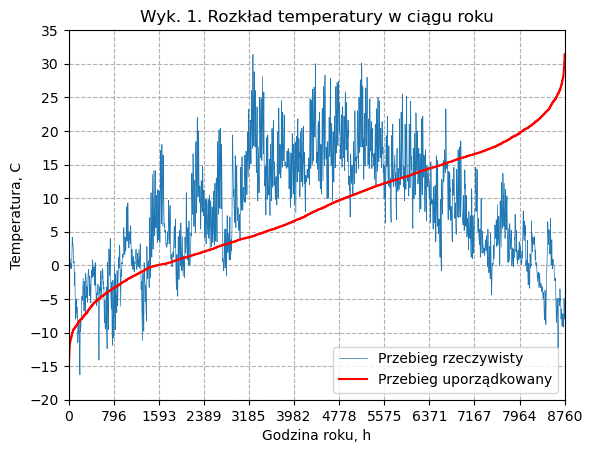

In [7]:
fig1, axs1 = plt.subplots(nrows=1, ncols =1)

((ax1)) = axs1

'Serie danych'
ax1.plot(dane.N, dane.DBT, linewidth = 0.5, label = 'Przebieg rzeczywisty')
ax1.plot(dane.N, dane.DBT.sort_values(ascending = True), label = 'Przebieg uporządkowany', c = 'red')

'Min/max osi X i Y'
ax1.set_xlim(0,8760)
ax1.set_ylim(-20,35)

'Etykiety osi'
ax1.set_xticks(np.linspace(0,8760,12, True))
ax1.set_yticks(np.arange(-20, 40, 5))

'Nazwy osi'
ax1.set_ylabel('Temperatura, C')
ax1.set_xlabel('Godzina roku, h')

'Siatka'
ax1.grid(linestyle = '--')

'Legenda'
ax1.legend()

'Tytuł wykresu'
ax1.set_title('Wyk. 1. Rozkład temperatury w ciągu roku')

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

# Rozkład produkcji ciepła

Przebieg rzeczywisty i uporządkowanu jest powszechnie stosowany w analize produckji ciepła przez ciepłownie oraz elektrociepłownie, a także w analize produkcji energii elektrycznej przez farmy waitrowe. 

Produkcja ciepła do celów grzewczych jest ściśle powiązana z temperaturą otoczenia, jednak nie jest to jednoznaczne z produkcją ciepła jedynie w sezonie grzewczym. Obiekty tego typu mogą produkować ciepło także po za nim w następujących przypadkach:

* całoroczna produkcja ciepła dla basenów, szpital czy lokalnych zakładów (np. w postaci pary technologicznej)
* produkcja ciepłej wody użytkowej przez cały rok, która nie jest silnie zależna od temperatury, a zapotrzebowanie na ciepło tego typu jest stosunkowo równomierne w ciągu roku

Sprawia to, że choć rozkłady temperatury oraz zapotrzebowania na ciepło są do siebie podobne to jednak nie takie same.

Poniżej przedstawiono rozkładu produkcji ciepła w elektrociepłowni.

# Wyk. 2. Przykładowe zapotrzebowanie na ciepło w systemie ciepłowniczym


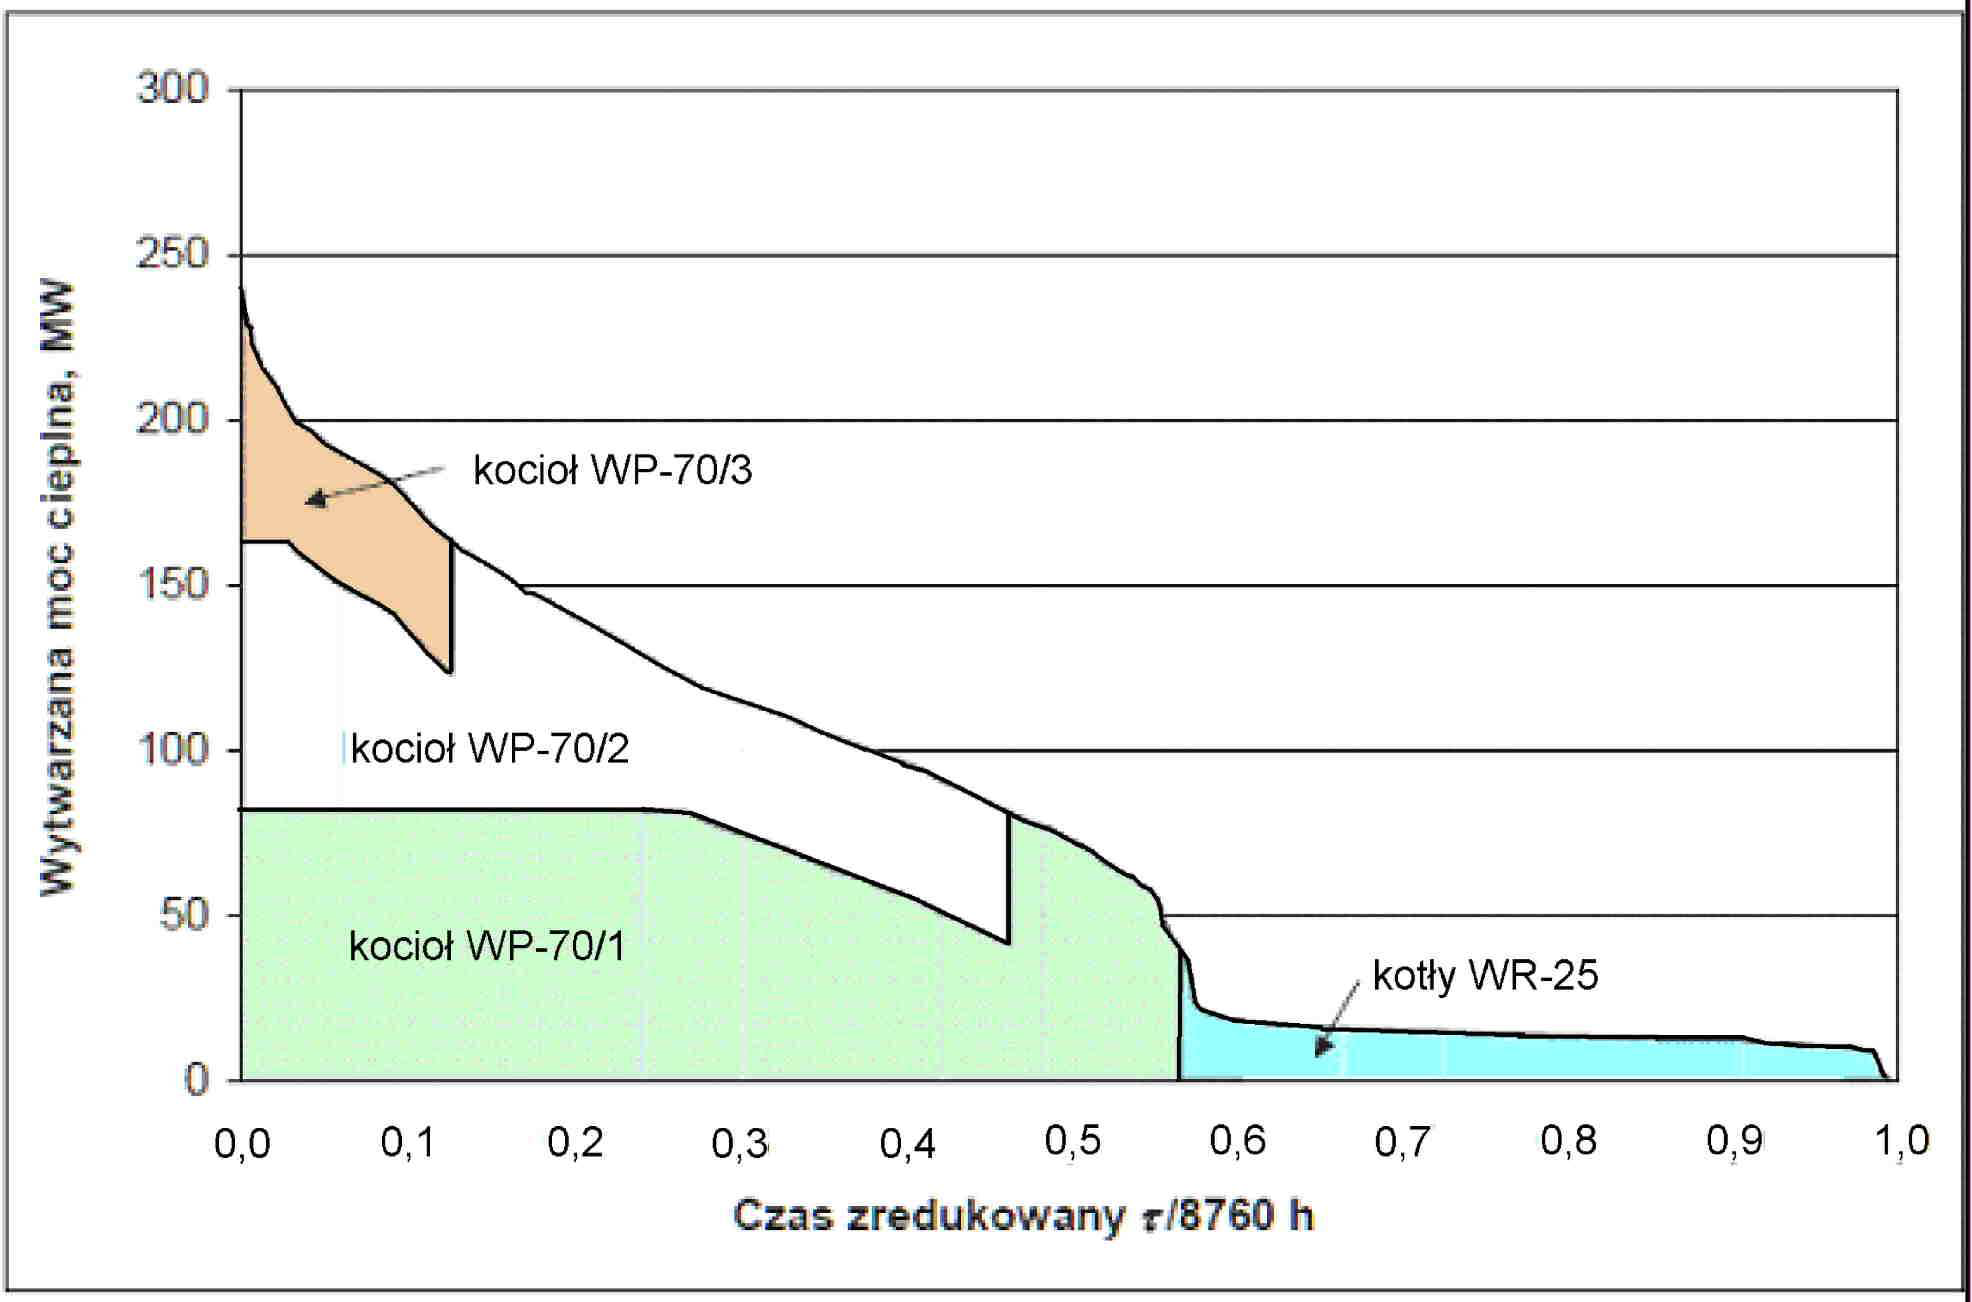

In [8]:
Image('zapotrzebowanie_na_ciepło.png')

Przyjmująć, że przedstawiony powyżej przykład jest reprezentatywny dla większości ciepłowni w Polsce, możliwe jest podjęcie próby odtworzenia rozkładu produkcji ciepła na podstawie informacji dostarczonych w treści zadania.

Przebieg można odtworzyć stosując narzędzia takie jak <b>WebPlotDigitalizer</b>:

https://automeris.io/WebPlotDigitizer/

Pozwoli to przekształcić wykres 2 do postaci tabeli, a następnie dopasować go do produckcji 16 PJ ciepła rocznie. Ponieważ dane klimatyczne są z rodzielczością co do godziny, jednostka osi Y (Wytwarzana moc cieplna, MW) zostanie zastąpiona przez MWh.

# Zdigitalizowany Wykres 2

In [9]:
# Ładowanie pliku csv stworzone za pomocą wyk. 2. oraz WebPlotDigitalier
zapotrzebowanie = pd.read_csv('zapotrzebowanie_na_cieplo.csv', sep = ';')
zapotrzebowanie.round({'N' : 0})

# Obróbka końcowego odcinka zdigitalizowanego wykresu 2 - uwzględnienie przerwy serwisowej
zapotrzebowanie.Q[zapotrzebowanie.Q < 0] = 0
zapotrzebowanie.Q[zapotrzebowanie.N > 8708] = 0

# Podgląd tabeli z danymi
zapotrzebowanie

,N,Q
0,1.0,236.267071
1,2.0,236.146466
2,3.0,236.068304
3,4.0,236.020764
4,5.0,235.992026
...,...,...
8755,8756.0,0.000000
8756,8757.0,0.000000
8757,8758.0,0.000000
8758,8759.0,0.000000


# Normalizacja godzinowego zapotrzebowania na ciepło

Wykres 2 jest istotny pod kątem przebiegu produkcji ciepła, jednak nie ze względu na występujące na nim konkretne wartości, lecz rozkład produkcji w ciągu roku. Widoczny tam przebieg można dodatkowo uogólnić poprzez normalizację wartości Q (MWh) do wartości bezwymiarowej QN = Q/Q_max
Do tabeli zapotr

In [10]:
# Maksymalna wartość z tabeli zapotrzebowanie
Q_max = zapotrzebowanie.Q.max()
Q_max

236.2670713201808

In [11]:
# Normalizacja
zapotrzebowanie['QN'] = (zapotrzebowanie.Q/zapotrzebowanie.Q.max())

# Podgląd tabeli
zapotrzebowanie

,N,Q,QN
0,1.0,236.267071,1.000000
1,2.0,236.146466,0.999490
2,3.0,236.068304,0.999159
3,4.0,236.020764,0.998958
4,5.0,235.992026,0.998836
...,...,...,...
8755,8756.0,0.000000,0.000000
8756,8757.0,0.000000,0.000000
8757,8758.0,0.000000,0.000000
8758,8759.0,0.000000,0.000000


# Wyk. 3. Uporządkowane, znormalizowane zapotrzebowanie na ciepło w ciągu roku

Opracowany na podstawie zdigitalizowane Wyk. 2. Będzie stanowić podstawę do oszacowania rozkładu produkjci ciepła 

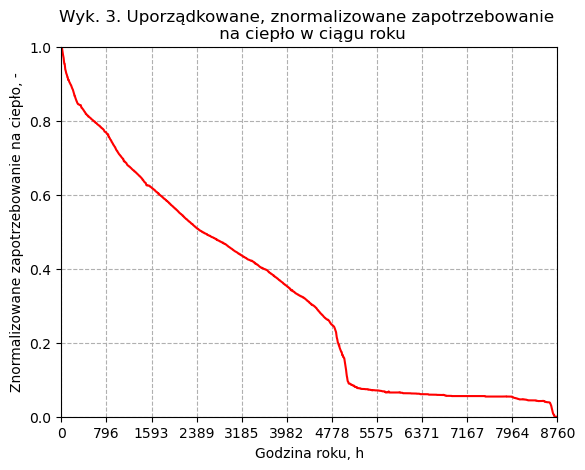

In [12]:
fig2, axs2 = plt.subplots(nrows=1, ncols =1)

((ax2)) = axs2

'Serie danych'
#ax2.plot(zapotrzebowanie.N, zapotrzebowanie.Q, linewidth = 0.5, label = 'Przebieg rzeczywisty')
ax2.plot(zapotrzebowanie.N, zapotrzebowanie.QN, label = 'Przebieg uporządkowany', c = 'red')

'Min/max osi X i Y'
ax2.set_xlim(0,8760)
ax2.set_ylim(0,1)

'Etykiety osi'
ax2.set_xticks(np.linspace(0,8760,12, True))
#ax2.set_yticks(np.arange(-20, 40, 5))

'Nazwy osi'
ax2.set_ylabel('Znormalizowane zapotrzebowanie na ciepło, -')
ax2.set_xlabel('Godzina roku, h')

'Siatka'
ax2.grid(which = 'major', linestyle = '--')

'Tytuł wykresu'
ax2.set_title('Wyk. 3. Uporządkowane, znormalizowane zapotrzebowanie \n na ciepło w ciągu roku')

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

# 16 PJ - ile to MWh?

In [13]:
ECMJ = (EC*10**15)/(10**6)
ECMWh = ECMJ/3600

print('Roczna produkcja ciepła:', ECMJ, ' MJ')
print('Roczna produkcja ciepła:', ECMWh, 'MWh')

Roczna produkcja ciepła: 16000000000.0  MJ
Roczna produkcja ciepła: 4444444.444444444 MWh


# Inżynieria odwrotna - oszacowanie godzinowej produkcji ciepła przez kogenerację gazową z treści zadania.

Wyprodukowane przez jednostkę 16 PJ, należy rozdzielić pomiędzy poszczególne godziny w ciągu roku. Nalezy to także powiązać z założonym uporządkowanym rozkładem temperatury w ciągu roku.

W pierwszej kolejności uporządkuję temperaturę otoczenia z tabeli dane.

In [14]:
# Dodanie kolumny ODBT do tabeli dane z uporządkowanym przebiegiem temperatury DBT
dane['ODBT'] = dane.DBT.sort_values(ascending = True).values

# Dodaję znormalizowane zapotrzebowanie na ciepło
dane['QN'] = zapotrzebowanie.QN.values

# Podgląd tabeli dane
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\520867711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['ODBT'] = dane.DBT.sort_values(ascending = True).values
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\520867711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['QN'] = zapotrzebowanie.QN.values


,N,M,D,H,DBT,ODBT,QN
0,1,1,1,0,2.8,-16.3,1.000000
1,2,1,1,1,3.1,-15.9,0.999490
2,3,1,1,2,3.5,-15.4,0.999159
3,4,1,1,3,3.8,-15.0,0.998958
4,5,1,1,4,3.3,-14.9,0.998836
...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000
8756,8757,12,31,20,-8.0,31.0,0.000000
8757,8758,12,31,21,-8.0,31.1,0.000000
8758,8759,12,31,22,-7.8,31.3,0.000000


## Definicja funkcji do przygotowania szacunkowego godzinowego przebiegu produkcji ciepła, tak aby roczna produkcja wynosiła 16 PJ (lub równoważność w MWh)

In [15]:
def funkcja_celu(Q, suma_docelowa = ECMWh):
    """
    Funkcja celu jest zdefiniowana jako różnica między sumą wartości w kolumnie Q (Q = QN * x) a wartością docelową suma_docelowa.
    
    Q - początkowe przybliżenie maksymalnego obciążenia kogeneracji gazowej produkującej 16 PJ ciepła rocznie (lub równoważności w MWh)
    suma_docelowa - suma rocznej produkcji ciepła przez kogenerację gazową
    """
    
    return np.abs((zapotrzebowanie['QN'] * Q).sum() - suma_docelowa)

In [16]:
Q_max = minimize(funkcja_celu, 1).x[0]
Q_max

1548.9067454050512

In [17]:
dane['OQ']=dane['QN']*Q_max
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\4073358535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['OQ']=dane['QN']*Q_max


,N,M,D,H,DBT,ODBT,QN,OQ
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620
...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000


Weryfikacja poprawności oszacowania

In [18]:
# Roczna produkcja ciepła w kogeneracji gazowej wyrażona w MWh
print('Wartość z treści zadania: ', ECMWh, ' MWh')

Wartość z treści zadania:  4444444.444444444  MWh


In [19]:
# Roczna produckja ciepła w kogeneracji gazowej wyrażona w MWh w odtworzonym
print('Wartość z treści zadania: ', dane.OQ.sum(), ' MWh')

Wartość z treści zadania:  4444444.444423065  MWh


In [20]:
# Różnica między wartością z treści zadania a sumą z odtworzenia rocznej produkcji ciepła
print(ECMWh-dane.OQ.sum(), ' MWh')

2.1379441022872925e-05  MWh


# Reorganizacja danych w celu uzyskania szacowanego przebiegu rzeczywistego

In [21]:
temperatura = dane[['DBT']]
temperatura 

,DBT
0,2.8
1,3.1
2,3.5
3,3.8
4,3.3
...,...
8755,-8.0
8756,-8.0
8757,-8.0
8758,-7.8


In [22]:
temperatura_uporządkowana = dane[['DBT']]
temperatura_uporządkowana = temperatura_uporządkowana.sort_values(by='DBT', ascending = True)

In [23]:
temperatura_uporządkowana['OQ'] =dane.OQ.values
temperatura_uporządkowana.sort_index()

,DBT,OQ
0,2.8,753.608032
1,3.1,742.154810
2,3.5,717.284031
3,3.8,699.540668
4,3.3,731.312264
...,...,...
8755,-8.0,1354.132584
8756,-8.0,1357.416155
8757,-8.0,1347.700893
8758,-7.8,1338.830200


In [24]:
dane['Q'] = temperatura_uporządkowana['OQ']
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\2686510951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Q'] = temperatura_uporządkowana['OQ']


,N,M,D,H,DBT,ODBT,QN,OQ,Q
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264
...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200


# Wykres 4. Rozkład produkcji ciepła kogeneracji gazowej o sumarycznej rocznej produkcji 16 PJ

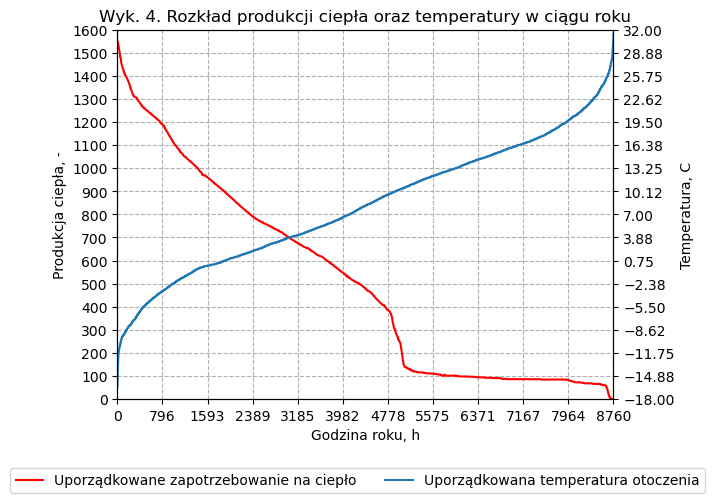

In [25]:
fig4, axs4 = plt.subplots(nrows=1, ncols =1)

((ax4)) = axs4

'Serie danych'
ax4.plot(dane.N, dane.OQ, label = 'Uporządkowane zapotrzebowanie na ciepło', c = 'red')

ax5 = ax4.twinx()

ax5.plot(dane.N, dane.ODBT, label = 'Uporządkowana temperatura otoczenia')

'Min/max osi X i Y'
ax4.set_xlim(0,8760)
ax4.set_ylim(0,1600)
ax5.set_ylim(0,32)

'Etykiety osi'
ax4.set_xticks(np.linspace(0,8760,12, True))
ax4.set_yticks(np.linspace(0,1600,17, True))
ax5.set_yticks(np.linspace(-18,32,17, True))

'Nazwy osi'
ax4.set_ylabel('Produkcja ciepła, -')
ax5.set_ylabel('Temperatura, C')
ax4.set_xlabel('Godzina roku, h')

'Siatka'
ax4.grid(linestyle='--')

'Tytuł wykresu'
ax4.set_title('Wyk. 4. Rozkład produkcji ciepła oraz temperatury w ciągu roku')

'Legenda'
fig4.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol = 2)

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

# Kogeneracja Gazowa

W treści zadania podano jedynie informację o produckji ciepła w kogeneracji gazowe. Może to być realizowane z wykorzystaniem następujących technologi:

* układ gazowo-parowy
* turbina gazowa
* kotły gazowe
* silniki gazowe

Możliwe jest jednoczesne wykorzystanie kilku technologi np. układu gazowo-parowego jako podstawy produkcji ciepła w sezonie grzewczym oraz silników gazowych lub kotłów gazowych w celu pokrycia zapotrzebowania szczytowego lub w poza sezonem grzewczym.

W przypadku rzeczywstych elektrociepłowni wykorzystujących jako paliwo gaz ziemny lub zaazotowany oraz układ gazowo-parowy do pokrycia zapotrzebowania w szczycie stosuje się kogeneracyjne silniki gazowe (EC Rzeszów) lub też jednostki opalane innymi paliwami (EC Lublin Wrotków).

* EC Lublin Wrotków: https://pgeenergiaciepla.pl/spolki-i-oddzialy/elektrocieplownie/oddzial-elektrocieplownia-w-lublinie
* EC Rzeszów https://pgeenergiaciepla.pl/spolki-i-oddzialy/elektrocieplownie/oddzial-elektrocieplownia-w-rzeszowie

Zakładam, że ciepło to jest produkowane w układzie gazowo-parowym, którego średnioroczne sprawności wynoszą:

* średnioroczna sprawność ogólna: 72,3 %
* średnioroczna sprawność elektryczna: 47,53 %
* średnioroczna sprawność wytwarzania energi cieplnej w kogeneracji: 32,47 %


Na podstawie danych z artykułu dostępnego na stronie energetykacieplna.pl:

https://www.energetykacieplna.pl/artykuly/oplacalnosc-blokow-skojarzonych-gazowo-parowych-wybrane-aspekty-37080-6#_

# Energia pierwotna potrzebna do dostarczenia 16 PJ (4 444 444 MWh) ciepła

Opierając się na publikacji 1 zakładam, że kogeneracja działa przez cały rok, koncentrując się na produkcji energii elektrycznej poza sezonem grzewczym. Jako umowną granicę pracy w reżimie typowym dla sezonu grzwczego przyjmuję temperaturę 12 st.C. Jeżeli temperatura wzrośnie powyżej 12 st.C elektrociepłownia zmienia swój reżim pracy.

1. https://elektroenergetyka.pl/upload/file/2011/8/Bartnik.pdf

Jest to założenie upraszczające, ponieważ w rzeczywsitych elektrociepłowniach wystepują także dodatkowe (np. szczytowe, rezerwowe) źródła wywtarzania ciepła.

# Uwzględnienie reżimu pracy elektrociepłowni

In [26]:
# Sprawności elektryczne
eta_el_lato = 0.554
eta_el_zima = 0.528

# Sprawności energetyczne
eta_lato = 0.582
eta_zima = 0.736

# Sprawności ciepłownicze
eta_cieplo_lato = eta_lato - eta_el_lato
eta_cieplo_zima = eta_zima - eta_el_zima

# Przyporządkowanie sprawności
dane['eta'] = dane.DBT.apply(lambda x: eta_lato if x > DBTG else eta_zima)

# Przyporządkowanie sprawności elektrycznej
dane['eta_el'] = dane.DBT.apply(lambda x: eta_el_lato if x > DBTG else eta_el_zima)

# Przyporządkowanie sprawności cieplnej
dane['eta_cieplo'] = dane.DBT.apply(lambda x: eta_cieplo_lato if x > DBTG else eta_cieplo_zima)
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\216491055.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['eta'] = dane.DBT.apply(lambda x: eta_lato if x > DBTG else eta_zima)
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\216491055.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['eta_el'] = dane.DBT.apply(lambda x: eta_el_lato if x > DBTG else eta_el_zima)
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\216491055.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208


# Wykres 5. Sprawność chwilowa kogeneracji gazowej w ciągu roku

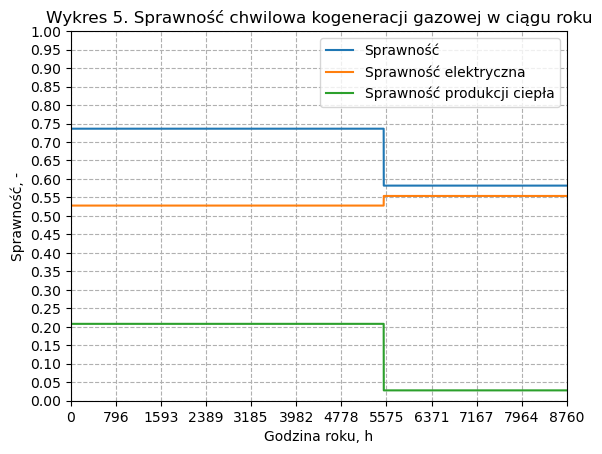

In [27]:
fig5, axs5 = plt.subplots(nrows=1, ncols =1)

((ax5)) = axs5

'Serie danych'
ax5.plot(dane.N, dane.eta.sort_values(ascending=False), label = 'Sprawność')
ax5.plot(dane.N, dane.eta_el.sort_values(ascending= True), label = 'Sprawność elektryczna')
ax5.plot(dane.N, dane.eta_cieplo.sort_values(ascending=False), label = 'Sprawność produkcji ciepła')

'Min/max osi X i Y'
ax5.set_xlim(0,8760)
ax5.set_ylim(0,1)

'Etykiety osi'
ax5.set_xticks(np.linspace(0,8760,12, True))
ax5.set_yticks(np.linspace(0,1,21, True))

'Nazwy osi'
ax5.set_ylabel('Sprawność, -')
ax5.set_xlabel('Godzina roku, h')

'Siatka'
ax5.grid(linestyle='--')

'Tytuł wykresu'
ax5.set_title('Wykres 5. Sprawność chwilowa kogeneracji gazowej w ciągu roku')

'Legenda'
ax5.legend()

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

In [28]:
dane['Ech'] = dane.Q/dane.eta_cieplo
dane['Nel'] = dane.eta_el*dane.Ech
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1613066110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Ech'] = dane.Q/dane.eta_cieplo
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1613066110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Nel'] = dane.eta_el*dane.Ech


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969


In [29]:
(dane.Q[0]+dane.Nel[0])/dane.Ech[0]

0.7359999999999999

In [30]:
dane[['Q','Ech', 'Nel']].describe()

,Q,Ech,Nel
count,8760.000000,8760.000000,8760.000000
mean,507.356672,3404.839627,1826.766985
std,425.945800,1421.165949,746.536620
min,0.000000,0.000000,0.000000
25%,92.516588,2612.230940,1423.165712
50%,478.325515,3265.605780,1741.117562
75%,831.719363,3998.650784,2163.178277
max,1548.906745,7446.667045,3931.840200


Energia chemiczna gazu zimnego: {dane.Ech.sum()}

In [31]:
dane.Ech.sum()

29826395.131478686

In [32]:
dane.Nel.sum()

16002478.792287618

In [33]:
(dane.Q.sum()+dane.Nel.sum())/dane.Ech.sum()

0.6855311594504783

# PES i wskaźnik skojarzenia

In [34]:
# PES - primary energy savings - wskaźnik wysokosprawnej kogenracji 
dane['PES'] = 1 - (1 / ((dane.eta_el/0.442)+(dane.eta_cieplo/0.88)))
# WS - wskaźnik skojarzenia wytwarzania energii w kogeneracji
dane['WS'] = dane.Nel/dane.Q
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1915364177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['PES'] = 1 - (1 / ((dane.eta_el/0.442)+(dane.eta_cieplo/0.88)))
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1915364177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['WS'] = dane.Nel/dane.Q


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462


In [35]:
# Roczne zużycie energi pierwotnej
print(dane.Ech.sum(), 'MWh')
print(dane.Ech.sum()* (10**6)/(10**15), 'PWh')
print(dane.Ech.sum()* (10**6)/(10**15) * 3600, 'PJ')

29826395.131478686 MWh
0.029826395131478688 PWh
107.37502247332327 PJ


In [36]:
# Roczna produkcja energi elektrycznej
print(dane.Nel.sum(), 'MWh')
print(dane.Nel.sum()* (10**6)/(10**15) * 3600, 'PJ')

16002478.792287618 MWh
57.608923652235426 PJ


# Zużycie gazu i emisja CO2 na podstawie danych KOBIZE:

https://www.kobize.pl/uploads/materialy/materialy_do_pobrania/monitorowanie_raportowanie_weryfikacja_emisji_w_eu_ets/WO_i_WE_do_monitorowania-ETS-2023.pdf

In [37]:
# Spalony gaz ziemny w metrach sześciennych normalnych Nm3
dane['Nm3'] = (dane.Ech*3600)/Wd
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1061769202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Nm3'] = (dane.Ech*3600)/Wd


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691


# Rynkowa cena energii elektrycznej

Źródło:
https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce

In [38]:
M1 = pd.read_csv('1.csv', sep=';', encoding='latin1')
M2 = pd.read_csv('2.csv', sep=';', encoding='latin1')
M3 = pd.read_csv('3.csv', sep=';', encoding='latin1')
M4 = pd.read_csv('4.csv', sep=';', encoding='latin1')
M5 = pd.read_csv('5.csv', sep=';', encoding='latin1')
M6 = pd.read_csv('6.csv', sep=';', encoding='latin1')
M7 = pd.read_csv('7.csv', sep=';', encoding='latin1')
M8 = pd.read_csv('8.csv', sep=';', encoding='latin1')
M9 = pd.read_csv('9.csv', sep=';', encoding='latin1')
M10 = pd.read_csv('10.csv', sep=';', encoding='latin1')
M11 = pd.read_csv('11.csv', sep=';', encoding='latin1')
M12 = pd.read_csv('12.csv', sep=';', encoding='latin1')

In [39]:
CE = pd.concat([M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, M11, M12])
CE.reset_index(inplace = True)
CE

,index,Data,Godzina,RCE
0,0,20230101,1,75.01
1,1,20230101,2,29.43
2,2,20230101,3,29.05
3,3,20230101,4,29.26
4,4,20230101,5,28.94
...,...,...,...,...
8755,739,20231231,20,231.57
8756,740,20231231,21,185.27
8757,741,20231231,22,195.04
8758,742,20231231,23,195.37


In [40]:
dane['RCE'] = CE['RCE'].astype(float)
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\2163818182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['RCE'] = CE['RCE'].astype(float)


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37


# Cena gazu

Do analizy przyjmuję cenę gazu z dokładnością co do kwartału.

https://www.ure.gov.pl/pl/paliwa-gazowe/ceny-wskazniki/7859,Srednie-kwartalne-ceny-zakupu-gazu-ziemnego-sprowadzanego-z-panstw-czlonkowskich.html

In [41]:
# Średnie kwartalne ceny gazu w 2023 - PLN/MWh
Q1 = 296.51
Q2 = 177.92 
Q3 = 167.09
Q4 = 201.20

def cena_gazu(M):
    
    """
    Przyporządkowanie kwartalnej ceny gazu
    """
    
    if M <= 3:
        return Q1
    elif M >3 and M<= 6:
        return Q2
    elif M>6 and M <=9:
        return Q3
    else:
        return Q4

dane['CG'] = dane.M.apply(lambda x: cena_gazu(x))
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\3939257585.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['CG'] = dane.M.apply(lambda x: cena_gazu(x))


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20


Zysk ze sprzedaży energii elektrycznej i ciepła

In [42]:
# Przychód ze sprzedaży energii elektrycznej - PLN
dane['PNel'] = dane.Nel*dane.RCE

# Przychód ze sprzedaży ciepła - PLN
dane['PC'] = dane.Q*CC2

# Koszt gazu zmienego - PLN
dane['KC'] = dane.Ech * dane.CG

# Przychód ze sprzedaży energii elektrycznej oraz ciepła - PLN
#dane['P'] = dane.PNel+ dane.PC - dane.KC - dane.KCO2

# Podgląd tabeli
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1828326264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['PNel'] = dane.Nel*dane.RCE
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1828326264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['PC'] = dane.Q*CC2
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1828326264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06


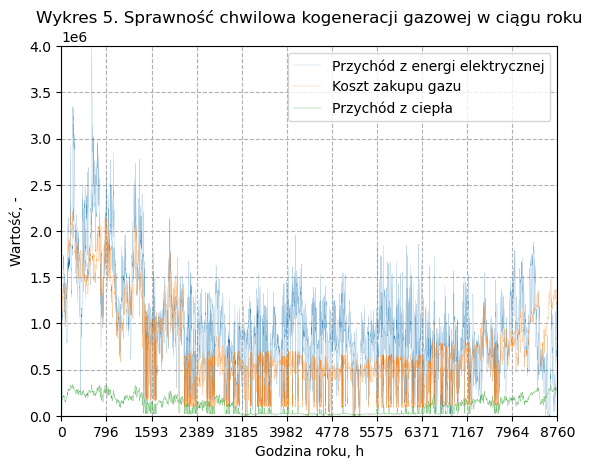

In [43]:
fig6, axs6 = plt.subplots(nrows=1, ncols =1)

((ax6)) = axs6

'Serie danych'
ax6.plot(dane.N, dane.PNel, label = 'Przychód z energi elektrycznej', linewidth = 0.1)
ax6.plot(dane.N, dane.KC, label = 'Koszt zakupu gazu', linewidth = 0.15)
ax6.plot(dane.N, dane.PC, label = 'Przychód z ciepła', linewidth = 0.2)
ax6.set_ylim(0,)

'Min/max osi X i Y'
ax6.set_xlim(0,8760)
ax6.set_ylim(0,4*10**6)

'Etykiety osi'
ax6.set_xticks(np.linspace(0,8760,12, True))
#ax5.set_yticks(np.linspace(0,1,21, True))

'Nazwy osi'
ax6.set_ylabel('Wartość, -')
ax6.set_xlabel('Godzina roku, h')

'Siatka'
ax6.grid(linestyle='--')

'Tytuł wykresu'
ax6.set_title('Wykres 5. Sprawność chwilowa kogeneracji gazowej w ciągu roku')

'Legenda'
ax6.legend()

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

# Pytanie przez ile godzin w ciągu roku prąd jest tańszy od gazu?

In [44]:
dane['ile'] =  np.where(dane.RCE <= dane.CG, 1, 0)
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1103550106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['ile'] =  np.where(dane.RCE <= dane.CG, 1, 0)


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1


In [45]:
dane.ile.sum()

510

# W 2023 r. energia elektryczna była tańsza od gazu zmienego przez 510H

# Emisja CO2

Na podstawie danych KOBIZE

In [46]:
# Emisja CO2 w tonach
dane['ECO2'] = dane.Ech*ECO2
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\1276437365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['ECO2'] = dane.Ech*ECO2


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953


In [47]:
# Dodaję kolumnę Y z rokiem
dane['Y'] = 2023
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\2910813085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Y'] = 2023


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023


In [48]:
dane['data'] = dane.Y.astype(str) + '-' + dane.M.astype(str) + '-' + dane.D.astype(str)
dane['data'] = pd.to_datetime(dane['data'])
dane

C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\2722194096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['data'] = dane.Y.astype(str) + '-' + dane.M.astype(str) + '-' + dane.D.astype(str)
C:\Users\Arek\AppData\Local\Temp\ipykernel_36412\2722194096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['data'] = pd.to_datetime(dane['data'])


,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31


# Wczytanie danych kosztach uprawnień do emisji CO2

https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rozliczeniowa-cena-uprawnien-do-emisji-co2-rcco2

In [49]:
ceny_CO2 = pd.read_csv('ceny_CO2.csv', sep =';')
ceny_CO2.data = pd.to_datetime(ceny_CO2.data)
ceny_CO2

,data,CtCO2
0,2023-01-01,389.38
1,2023-01-02,397.28
2,2023-01-03,385.07
3,2023-01-04,357.65
4,2023-01-05,362.80
...,...,...
360,2023-12-27,341.15
361,2023-12-28,342.71
362,2023-12-29,343.87
363,2023-12-30,342.58


# Przypisanie cen z df ceny_CO2 do df dane 

In [50]:
ceny_CO2.dtypes

data     datetime64[ns]
CtCO2           float64
dtype: object

In [51]:
dane = pd.merge(dane, ceny_CO2, on = 'data', how = 'left')

# Koszt zakupu uprawnień do emisji CO2

Nie uwzględniam przydziału darmowych uprawnień.

In [52]:
dane['KCO2'] = dane.ECO2*dane.CtCO2
dane

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01,389.38,281770.016434
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01,389.38,277487.717984
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01,389.38,268188.666573
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01,389.38,261554.518017
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01,389.38,273433.747994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31,343.05,447142.607737
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31,343.05,443942.331013
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31,343.05,441020.261049


# Przez ile godzin w roku prąd jest tańszy niż gaz razem z kosztem uprawnień do emisji CO2?

In [53]:
dane['ile2'] =  np.where(dane.RCE <= (dane.CG+dane.CtCO2), 1, 0)
dane

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01,389.38,281770.016434,1
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01,389.38,277487.717984,1
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01,389.38,268188.666573,1
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01,389.38,261554.518017,1
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01,389.38,273433.747994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937,1
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31,343.05,447142.607737,1
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31,343.05,443942.331013,1
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31,343.05,441020.261049,1


In [54]:
dane.ile2.sum()

6354

# Dekarbonizacja elektrociepłowni

Dekarbonizacja elektrociepłowni może być przeprowadzona na dwa sposoby:

1. Kompleksowa wymiana technologi wykorzystujących paliwa kopalne na inne takie jak pompy ciepła, kotły elektryczne czy potencjalnie technologie wykorzystujące wodór
2. Proces reduckji emisji zaniczyszczeń poprzez odciążanie istniejącej technologii innymi technologiami bezemisyjnymi wymienionymi w pkt. 1.

Realizację wg. pkt. 2 można spotkać w Oddziale Wybrzeże PGE, gdzie zastosowano kotły elektryczne do pokrycia szczytowego zapotrzebowania na energię elektryczną lub do produckji ciepła w przypadku naproduckji energii elektrycznej z OZE.

https://www.gramwzielone.pl/trendy/20140431/pge-wdrozylo-technologie-power-to-heat-jakie-efekty

Zakładam ścieżkę nr 2. Do analizy przyjmuję zastosowanie 5 kotłów elektrycznych o mocy 25 MW, sprawności 99 oraz nakłądzie jednostkowym na poziomie 0,18 MLN Euro/MW

https://ens.dk/en/our-services/projections-and-models/technology-data/technology-data-generation-electricity-and
https://backend.orbit.dtu.dk/ws/portalfiles/portal/126597670/Electric_boilers_in_district_heating_systems_Lule_2016_2_.pdf

In [55]:
# Definicja funkcji, która stosuje ograniczenia i zwraca odpowiednie wartości dla kolumny QF
# ciepła wyprodukowane z wykorzystaniem kotłów szczytowych
def apply_constraints(row):
    if row['RCE'] <= row['CG']:
        if row['Q'] < 125:
            return row['Q']
        else:
            return 125
    else:
        return 0

dane['QEF'] = dane.apply(apply_constraints, axis=1) #Ciepło produkowane przez kotły elektryczne
dane['NelEF'] = dane.QEF/0.99 # Energia elektryczna pobierana przez kotły elektryczne
dane 

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2,QEF,NelEF
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01,389.38,281770.016434,1,125.0,126.262626
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01,389.38,277487.717984,1,125.0,126.262626
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01,389.38,268188.666573,1,125.0,126.262626
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01,389.38,261554.518017,1,125.0,126.262626
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01,389.38,273433.747994,1,125.0,126.262626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937,1,0.0,0.000000
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31,343.05,447142.607737,1,125.0,126.262626
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31,343.05,443942.331013,1,125.0,126.262626
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31,343.05,441020.261049,1,125.0,126.262626


In [56]:
# Zmiany jakie pwoduje zastosowanie kotłów w produckji energii dla wartości: Q, Ech, Nel, Nm3, ECO2, KCO2
dane2 = dane.copy()
dane2

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2,QEF,NelEF
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,753.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01,389.38,281770.016434,1,125.0,126.262626
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,742.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01,389.38,277487.717984,1,125.0,126.262626
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,717.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01,389.38,268188.666573,1,125.0,126.262626
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,699.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01,389.38,261554.518017,1,125.0,126.262626
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,731.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01,389.38,273433.747994,1,125.0,126.262626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937,1,0.0,0.000000
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1357.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31,343.05,447142.607737,1,125.0,126.262626
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1347.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31,343.05,443942.331013,1,125.0,126.262626
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1338.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31,343.05,441020.261049,1,125.0,126.262626


In [57]:
dane2.Q = dane2.Q - dane2.QEF
dane2

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2,QEF,NelEF
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,628.608032,0.736,0.528,0.208,3623.115537,1913.005003,0.301156,2.538462,355885.837155,75.01,296.51,143494.505299,163159.153276,1.074290e+06,1,723.637620,2023,2023-01-01,389.38,281770.016434,1,125.0,126.262626
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,617.154810,0.736,0.528,0.208,3568.051970,1883.931440,0.301156,2.538462,350477.137578,29.43,296.51,55444.102285,160679.484935,1.057963e+06,1,712.639884,2023,2023-01-01,389.38,277487.717984,1,125.0,126.262626
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,592.284031,0.736,0.528,0.208,3448.480917,1820.797924,0.301156,2.538462,338732.095511,29.05,296.51,52894.179694,155294.861781,1.022509e+06,1,688.758197,2023,2023-01-01,389.38,268188.666573,1,125.0,126.262626
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,574.540668,0.736,0.528,0.208,3363.176288,1775.757080,0.301156,2.538462,330352.923225,29.26,296.51,51958.652160,151453.352756,9.972154e+05,1,671.720474,2023,2023-01-01,389.38,261554.518017,1,125.0,126.262626
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,606.312264,0.736,0.528,0.208,3515.924345,1856.408054,0.301156,2.538462,345356.825197,28.94,296.51,53724.449094,158332.030371,1.042507e+06,1,702.228538,2023,2023-01-01,389.38,273433.747994,1,125.0,126.262626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937,1,0.0,0.000000
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1232.416155,0.736,0.528,0.208,6526.039205,3445.748700,0.301156,2.538462,641029.771827,185.27,201.20,638393.861679,293886.027137,1.313039e+06,1,1303.432758,2023,2023-12-31,343.05,447142.607737,1,125.0,126.262626
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1222.700893,0.736,0.528,0.208,6479.331217,3421.086883,0.301156,2.538462,636441.811247,195.04,201.20,667248.785607,291782.634180,1.303641e+06,1,1294.103865,2023,2023-12-31,343.05,443942.331013,1,125.0,126.262626
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1213.830200,0.736,0.528,0.208,6436.683653,3398.568969,0.301156,2.538462,632252.691691,195.37,201.20,663978.419422,289862.093579,1.295061e+06,1,1285.585953,2023,2023-12-31,343.05,441020.261049,1,125.0,126.262626


In [67]:
dane2['Ech'] = dane2.Q/dane2.eta_cieplo
dane2['Nm3'] = (dane2.Ech*3600)/Wd
dane2['Nel'] = (dane2.eta_el*dane2.Ech)-dane2.NelEF

# Emisja CO2 w tonach
dane2['ECO2'] = dane2.Ech*ECO2

# Koszt emisji CO2 
dane2['KCO2'] = dane2.ECO2*dane2.CtCO2

# Przychód ze sprzedaży energii elektrycznej - PLN
dane2['PNel'] = dane2.Nel*dane2.RCE

# Przychód ze sprzedaży ciepła - PLN
dane2['PC'] = (dane2.Q+dane2.QEF)*CC2

# Koszt gazu zmienego - PLN
dane2['KC'] = dane2.Ech * dane2.CG

# Przychód ze sprzedaży energii elektrycznej oraz ciepła - PLN
dane2['P'] = dane2.PNel+ dane2.PC - dane2.KC - dane2.KCO2

# Podgląd tabeli
dane2

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2,QEF,NelEF,P
0,1,1,1,0,2.8,-16.3,1.000000,1548.906745,628.608032,0.736,0.528,0.208,3022.153998,1469.434685,0.301156,2.538462,296855.508684,75.01,296.51,110222.295703,163159.153276,8.960989e+05,1,603.608774,2023,2023-01-01,389.38,235033.184318,1,125.0,126.262626,-857750.617324
1,2,1,1,1,3.1,-15.9,0.999490,1548.116090,617.154810,0.736,0.528,0.208,2967.090432,1440.361122,0.301156,2.538462,291446.809107,29.43,296.51,42389.827809,160679.484935,8.797720e+05,1,592.611038,2023,2023-01-01,389.38,230750.885869,1,125.0,126.262626,-907453.556998
2,3,1,1,2,3.5,-15.4,0.999159,1547.603679,592.284031,0.736,0.528,0.208,2847.519378,1377.227606,0.301156,2.538462,279701.767040,29.05,296.51,40008.461940,155294.861781,8.443180e+05,1,568.729350,2023,2023-01-01,389.38,221451.834458,1,125.0,126.262626,-870466.481608
3,4,1,1,3,3.8,-15.0,0.998958,1547.292020,574.540668,0.736,0.528,0.208,2762.214749,1332.186761,0.301156,2.538462,271322.594754,29.26,296.51,38979.784639,151453.352756,8.190243e+05,1,551.691627,2023,2023-01-01,389.38,214817.685901,1,125.0,126.262626,-843408.843842
4,5,1,1,4,3.3,-14.9,0.998836,1547.103620,606.312264,0.736,0.528,0.208,2914.962807,1412.837736,0.301156,2.538462,286326.496726,28.94,296.51,40887.524074,158332.030371,8.643156e+05,1,582.199692,2023,2023-01-01,389.38,226696.915878,1,125.0,126.262626,-891792.983320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,12,31,19,-8.0,30.1,0.000000,0.000000,1354.132584,0.736,0.528,0.208,6510.252806,3437.413482,0.301156,2.538462,639479.129651,231.57,201.20,796001.839931,293175.120892,1.309863e+06,0,1300.279772,2023,2023-12-31,343.05,446060.975937,1,0.0,0.000000,-666746.879688
8756,8757,12,31,20,-8.0,31.0,0.000000,0.000000,1232.416155,0.736,0.528,0.208,5925.077666,3002.178382,0.301156,2.538462,581999.443356,185.27,201.20,556213.588757,293886.027137,1.192126e+06,1,1183.403912,2023,2023-12-31,343.05,405966.712064,1,125.0,126.262626,-747992.722647
8757,8758,12,31,21,-8.0,31.1,0.000000,0.000000,1222.700893,0.736,0.528,0.208,5878.369679,2977.516564,0.301156,2.538462,577411.482776,195.04,201.20,580734.830673,291782.634180,1.182728e+06,1,1174.075019,2023,2023-12-31,343.05,402766.435340,1,125.0,126.262626,-712976.949866
8758,8759,12,31,22,-7.8,31.3,0.000000,0.000000,1213.830200,0.736,0.528,0.208,5835.722114,2954.998650,0.301156,2.538462,573222.363220,195.37,201.20,577318.086283,289862.093579,1.174147e+06,1,1165.557106,2023,2023-12-31,343.05,399844.365376,1,125.0,126.262626,-706811.474941


# LCOH

https://ens.dk/en/our-services/projections-and-models/technology-data/technology-data-generation-electricity-and
https://backend.orbit.dtu.dk/ws/portalfiles/portal/126597670/Electric_boilers_in_district_heating_systems_Lule_2016_2_.pdf

Założenia:
* Koszt kotła elektrycznego: 0.18 mln euro/MWt
* Okres eksploatacji: 25 lat
* Koszty eksploatacji i serwisowania:  1169.71 euro/MWt 
* Kurs euro: 4.30 PLN/Euro

In [68]:
# Koszt kotłów elektrycznych
KEF = 5 * 0.18*10**6*4.30
KEF

3869999.9999999995

In [88]:
# Roczna sprawnośc kogenracji
(dane.Nel.sum()+dane.Q.sum())/dane.Ech.sum()

0.6855311594504783

In [89]:
# Srednia roczna sprawność produkcji ciepła
dane.Q.sum()/dane.Ech.sum()

0.14901044611094863

In [90]:
# Roczne zużycie energii pierwotnej MWh - bez dekarbonizacji
dane.Ech.sum()

29826395.131478686

In [72]:
# Roczne zużycie energii pierwotnej MWh - dekarbonizacja
dane2.Ech.sum()

29152495.147687282

In [91]:
# Roczne zużycie energii pierwotnej MWh - różnica
dane.Ech.sum()-dane2.Ech.sum()

673899.9837914035

In [92]:
# Roczna ilość zużytego gazu Nm3 - bez dekarbonizacji
dane.Nm3.sum()

2929741404.4562964

In [93]:
# Roczna ilość zużytego gazu Nm3 - dekarbonizacja
dane2.Nm3.sum()

2863546590.223035

In [83]:
# Roczna ilość zużytego gazu Nm3 - różnica
dane.Nm3.sum()-dane2.Nm3.sum()

66194814.233261585

In [183]:
# Roczna produkcja energi elektrycznej MWh - bez dekarbonizacji
dane.Nel.sum()

16002478.792287618

In [94]:
# Roczna produkcja energi elektrycznej MWh - dekarbonizacja
dane2.Nel.sum()

15576878.263566572

In [85]:
# Roczna produkcja energi elektrycznej MWh - różnica
dane.Nel.sum() - dane2.Nel.sum()

425600.5287210457

In [184]:
# Roczny przychód ze sprzedaży energii elektrycznej PLN - bez dekarbonizacji
dane.PNel.sum()

8182798591.864496

In [95]:
# Roczny przychód ze sprzedaży energii elektrycznej PLN - dekarbonizacja
dane2.PNel.sum()

8145159097.483641

In [86]:
# Roczny przychód ze sprzedaży energii elektrycznej PLN - różnica
dane2.PNel.sum() - dane.PNel.sum()

37639494.38085556

In [186]:
# Roczny koszt zakupu gazu ziemnego PLN - bez dekarbonizacji
dane.KC.sum()

6603396114.050983

In [79]:
# Roczny koszt zakupu gazu ziemnego PLN - dekarbonizacja
dane2.KC.sum()

6473991860.803942

In [96]:
# Roczny koszt zakupu gazu ziemnego PLN - różnica
dane.KC.sum()-dane2.KC.sum()

129404253.2470417

In [187]:
# Roczny koszt zakupu uprawnień do emisji CO2 PLN - bez dekarbonizacji
dane.KCO2.sum()

2281865628.0710883

In [80]:
# Roczny koszt zakupu uprawnień do emisji CO2 PLN - dekarbonizacji
dane2.KCO2.sum()

2231857858.633784

In [81]:
# Roczny koszt zakupu uprawnień do emisji CO2 PLN - różnica
dane.KCO2.sum()-dane2.KCO2.sum()

50007769.4373045

In [190]:
# Roczny przychód ze sprzedaży ciepła, PLN - bez dekarbonizacji
dane.PC.sum()

962239999.9953711

In [78]:
# Roczny przychód ze sprzedaży ciepła, PLN - dekarbonizacja
dane2.PC.sum()

962239999.9953711

# Ilustracja pracy w dzień zimowy

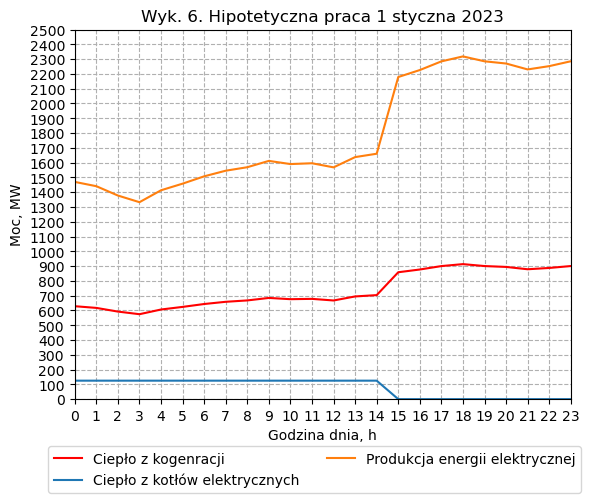

In [377]:
fig6, axs6 = plt.subplots(nrows=1, ncols =1)

((ax6)) = axs6

'Serie danych'
ax6.plot(dane2.index, dane2.Q, label = 'Ciepło z kogenracji', c = 'red')
ax6.plot(dane2.index, dane2.QEF, label = 'Ciepło z kotłów elektrycznych')
ax6.plot(dane2.index, dane2.Nel, label = 'Produkcja energii elektrycznej')

'Min/max osi X i Y'
ax6.set_xlim(0,23)
ax6.set_ylim(0,2500)

'Etykiety osi'
ax6.set_xticks(np.arange(0,24,1))
ax6.set_yticks(np.linspace(0,2500,26, True))

'Nazwy osi'
ax6.set_ylabel('Moc, MW')
ax6.set_xlabel('Godzina dnia, h')

'Siatka'
ax6.grid(linestyle='--')

'Tytuł wykresu'
ax6.set_title('Wyk. 6. Hipotetyczna praca 1 styczna 2023')

'Legenda'
fig6.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol = 2)

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

# Ilustracja pracy za dzień letni

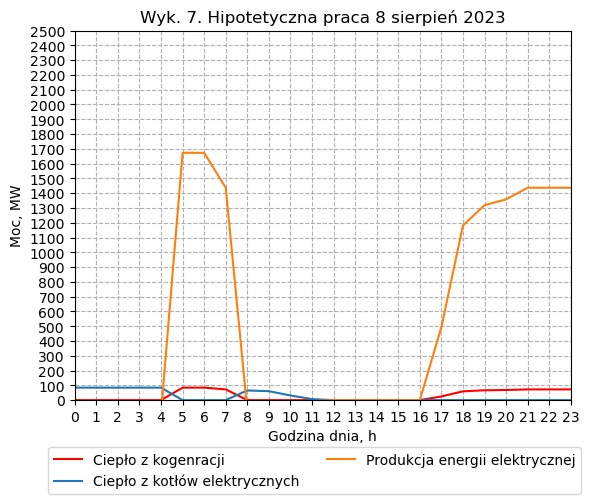

In [391]:
fig7, axs7 = plt.subplots(nrows=1, ncols =1)

((ax7)) = axs7

'Serie danych'
ax7.plot(dane2.index, dane2.Q, label = 'Ciepło z kogenracji', c = 'red')
ax7.plot(dane2.index, dane2.QEF, label = 'Ciepło z kotłów elektrycznych')
ax7.plot(dane2.index, dane2.Nel, label = 'Produkcja energii elektrycznej')

'Min/max osi X i Y'
ax7.set_xlim(5256,5279)
ax7.set_ylim(0,1600)

'Etykiety osi'
ax7.set_xticks(np.arange(5256,5280,1))
ax7.set_xticklabels(np.arange(0,24,1))
ax7.set_yticks(np.linspace(0,2500,26, True))

'Nazwy osi'
ax7.set_ylabel('Moc, MW')
ax7.set_xlabel('Godzina dnia, h')

'Siatka'
ax7.grid(linestyle='--')

'Tytuł wykresu'
ax7.set_title('Wyk. 7. Hipotetyczna praca 8 sierpień 2023')

'Legenda'
fig7.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol = 2)

'Automatyczne dopasowanie wykresu do rozmiaru okna, tak aby zmieścił się w nim w całości'
plt.tight_layout;

In [392]:
dane2[5256:5279]

,N,M,D,H,DBT,ODBT,QN,OQ,Q,eta,eta_el,eta_cieplo,Ech,Nel,PES,WS,Nm3,RCE,CG,PNel,PC,KC,ile,ECO2,Y,data,CtCO2,KCO2,ile2,QEF,NelEF,P
5256,5257,8,8,0,18.6,11.2,0.077065,119.365894,0.000000,0.582,0.554,0.028,0.000000,-85.412295,0.221918,19.785714,296637.515272,70.87,167.09,-6053.169323,18307.182409,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,84.558172,85.412295,12254.013086
5257,5258,8,8,1,18.3,11.2,0.077067,119.369569,0.000000,0.582,0.554,0.028,0.000000,-85.412295,0.221918,19.785714,296637.515272,67.37,167.09,-5754.226291,18307.182409,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,84.558172,85.412295,12552.956118
5258,5259,8,8,2,18.1,11.2,0.077071,119.375448,0.000000,0.582,0.554,0.028,0.000000,-85.412295,0.221918,19.785714,296637.515272,67.37,167.09,-5754.226291,18307.182409,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,84.558172,85.412295,12552.956118
5259,5260,8,8,3,17.8,11.2,0.077075,119.382688,0.000000,0.582,0.554,0.028,0.000000,-85.412295,0.221918,19.785714,296637.515271,66.37,167.09,-5668.813997,18307.182409,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,84.558172,85.412295,12638.368412
5260,5261,8,8,4,18.1,11.2,0.077080,119.389349,0.000000,0.582,0.554,0.028,0.000000,-85.412295,0.221918,19.785714,296637.515272,65.91,167.09,-5629.524341,18307.182409,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,84.558172,85.412295,12677.658068
5261,5262,8,8,5,18.3,11.2,0.077082,119.393105,84.558172,0.582,0.554,0.028,3019.934704,1673.043826,0.221918,19.785714,296637.515272,168.51,167.09,281924.615130,18307.182409,504600.889706,0,603.165519,2023,2023-08-08,371.59,224130.275048,1,0.000000,0.000000,-428499.367215
5262,5263,8,8,6,18.6,11.2,0.077081,119.391630,84.558172,0.582,0.554,0.028,3019.934704,1673.043826,0.221918,19.785714,296637.515272,171.35,167.09,286676.059596,18307.182409,504600.889706,0,603.165519,2023,2023-08-08,371.59,224130.275048,1,0.000000,0.000000,-423747.922749
5263,5264,8,8,7,20.7,11.2,0.077075,119.382596,72.611196,0.582,0.554,0.028,2593.256985,1436.664370,0.221918,19.785714,254726.470597,170.16,167.09,244462.809182,15720.614290,433307.309687,0,517.946031,2023,2023-08-08,371.59,192463.565725,1,0.000000,0.000000,-365587.451939
5264,5265,8,8,8,22.7,11.2,0.077063,119.364107,0.000000,0.582,0.554,0.028,0.000000,-66.244839,0.221918,19.785714,230068.805114,117.43,167.09,-7779.131497,14198.849994,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,65.582391,66.244839,6419.718497
5265,5266,8,8,9,24.8,11.3,0.077048,119.340842,0.000000,0.582,0.554,0.028,0.000000,-61.294983,0.221918,19.785714,212877.919140,74.87,167.09,-4589.155403,13137.902982,0.000000,1,0.000000,2023,2023-08-08,371.59,0.000000,1,60.682034,61.294983,8548.747580
